## Load Data

In [1]:
import numpy as np
import pandas as pd
def load_data():
    for i in range(5):
        i += 1
        if i==1:
            train_seqs = np.load(f'/content/drive/MyDrive/18.s997/project/embeddings/embeddings_20_1000G_sequences_{i}.npy')
        else:
            train_seqs = np.concatenate((train_seqs, np.load(f'/content/drive/MyDrive/18.s997/project/embeddings/embeddings_20_1000G_sequences_{i}.npy')))


    return train_seqs

labels_dev = np.load(f'/content/drive/MyDrive/18.s997/project/embeddings/y_train_dev.npy')
labels_hk = np.load(f'/content/drive/MyDrive/18.s997/project/embeddings/y_train_hk.npy')
train_seqs = load_data()

In [ ]:
def load_val_data():
    val123 = np.load(f'/content/drive/MyDrive/18.s997/project/embeddings/embeddings_20_1000G_valid_123.npy')
    val123 = np.concatenate((val123, np.load(f'/content/drive/MyDrive/18.s997/project/embeddings/embeddings_20_1000G_valid_45.npy')))

    return val123

val_labels_dev = np.load(f'/content/drive/MyDrive/18.s997/project/embeddings/y_valid_dev.npy')
val_labels_hk = np.load(f'/content/drive/MyDrive/18.s997/project/embeddings/y_valid_hk.npy')
val_seqs = load_val_data()

In [ ]:
def load_test_data():
    test123 = np.load(f'/content/drive/MyDrive/18.s997/project/embeddings/embeddings_20_1000G_test_123.npy')
    test123 = np.concatenate((test123, np.load(f'/content/drive/MyDrive/18.s997/project/embeddings/embeddings_20_1000G_test_45.npy')))
    return test123
test_seqs = load_test_data()
test_labels_dev = np.load(f'/content/drive/MyDrive/18.s997/project/embeddings/y_test_dev.npy')
test_labels_hk = np.load(f'/content/drive/MyDrive/18.s997/project/embeddings/y_test_hk.npy')

In [ ]:
labels_dev = np.load(f'/content/drive/MyDrive/18.s997/project/embeddings/y_train_dev.npy')
labels_hk = np.load(f'/content/drive/MyDrive/18.s997/project/embeddings/y_train_hk.npy')
train_seqs = load_data()

In [ ]:
print(val_seqs.shape)
print(val_labels_dev.shape)
print(val_labels_hk.shape)

(40570, 54, 1280)
(40570,)
(40570,)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import optim
import tqdm

class CustomDataset(Dataset):
    def __init__(self, train_seqs, labels1, labels2):
        self.seqs = train_seqs
        self.labels1 = labels1
        self.labels2 = labels2

    def __getitem__(self, index):
        seq = self.seqs[index]
        label1 = self.labels1[index]
        label2 = self.labels2[index]
        return seq, label1, label2

    def __len__(self):
        return len(self.seqs)

In [ ]:
batch_size = 32
train_dataset = CustomDataset(train_seqs, labels_dev, labels_hk)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

val_dataset = CustomDataset(val_seqs, val_labels_dev, val_labels_hk)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
test_dataset = CustomDataset(test_seqs, test_labels_dev, test_labels_hk)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Two Layer GRU

In [ ]:
class TwoLayerGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(TwoLayerGRU, self).__init__()

        self.gru1 = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.gru2 = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        self.fc1 = nn.Linear(hidden_size, 1)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out1, _ = self.gru1(x)
        out2, _ = self.gru2(out1)

        fc_out1 = self.fc1(out2[:, -1, :])
        fc_out2 = self.fc2(out2[:, -1, :])

        return fc_out1, fc_out2

## GRU Adapted

In [ ]:
class GRU_LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.5):
        super(GRU_LSTM, self).__init__()

        self.hidden_size = hidden_size

        # GRU layer
        self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout = dropout_prob, bidirectional=True)

        # LSTM layer
        self.lstm = nn.LSTM(2 * hidden_size, 2 * hidden_size, batch_first=True, bidirectional=True)

        # Fully connected layers
        self.fc1_dev = nn.Linear(4 * hidden_size, 100)
        self.fc2_dev = nn.Linear(100, output_size)

        self.fc1_hk = nn.Linear(4 * hidden_size, 100)
        self.fc2_hk = nn.Linear(100, output_size)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_prob)



        # Define the output layer
        self.fc_hk = nn.Linear(hidden_size, 1)
        self.fc_dev = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # GRU layer
        gru_out, _ = self.gru(x)
        # print(gru_out.shape)
        # LSTM layer
        lstm_out, _ = self.lstm(gru_out)
        # print(lstm_out.shape)

        # Fully connected layer
        # print('shape', self.fc1_dev(lstm_out[:, -1, :]).shape)
        dev_out1 = self.fc1_dev(lstm_out[:, -1, :])  # Taking only the last output
        dev_out2 = self.fc2_dev(dev_out1)
        # dev_out2 = self.dropout(self.fc2_dev(dev_out1))


        # Fully connected layer
        # print(self.fc1_hk(lstm_out[:, -1, :]))
        hk_out1 = self.fc1_hk(lstm_out[:, -1, :])  # Taking only the last output
        hk_out2 = self.fc2_hk(hk_out1)
        # hk_out2 = self.dropout(self.fc2_hk(hk_out1))

        return dev_out2, hk_out2

### With validation loop

In [ ]:
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TwoLayerGRU(input_size=1280, hidden_size=64, num_layers=2, output_size=1).to(device)
# model = GRU_LSTM(input_size=1280, hidden_size=32, num_layers=3, output_size=1).to(device)
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training loop

train_losses = []
val_losses = []

num_epochs = 30
for epoch in range(num_epochs):
    model.train()  # Set the model to train mode

    epoch_loss = 0.0
    for inputs, targets1, targets2 in tqdm(train_dataloader):
        inputs, targets1, targets2 = inputs.to(device), targets1.to(device), targets2.to(device)

        optimizer.zero_grad()
        outputs1, outputs2 = model(inputs)

        targets1 = targets1.unsqueeze(1)
        targets2 = targets2.unsqueeze(1)
        # print(targets1.shape)
        # print(outputs1.shape)
        loss1 = criterion(outputs1, targets1.float())
        loss2 = criterion(outputs2, targets2.float())

        loss = loss1 + loss2
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Compute validation loss
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets1, val_targets2 in val_dataloader:
            val_inputs, val_targets1, val_targets2 = val_inputs.to(device), val_targets1.to(device), val_targets2.to(device)

            val_outputs1, val_outputs2 = model(val_inputs)

            val_targets1 = val_targets1.unsqueeze(1)
            val_targets2 = val_targets2.unsqueeze(1)

            val_loss1 = criterion(val_outputs1, val_targets1.float())
            val_loss2 = criterion(val_outputs2, val_targets2.float())

            val_loss += (val_loss1 + val_loss2).item()

    # Print training and validation loss for the epoch
    train_loss_epoch = epoch_loss / len(train_dataloader)
    val_loss_epoch = val_loss / len(val_dataloader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss_epoch:.4f}, Validation Loss: {val_loss_epoch:.4f}")

    train_losses.append(train_loss_epoch)
    val_losses.append(val_loss_epoch)


  0%|          | 0/1563 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (54) must match the size of tensor b (32) at non-singleton dimension 1

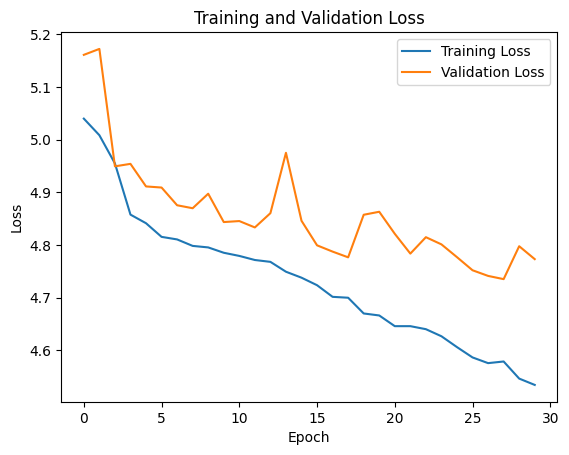

In [ ]:
import matplotlib.pyplot as plt
# Plot the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

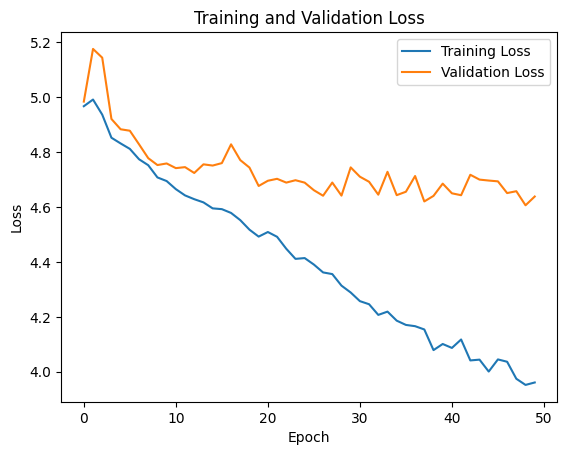

In [ ]:
import matplotlib.pyplot as plt
# Plot the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Evaluate Model

In [ ]:
# Set the model to evaluation mode
model.eval()

# Lists to store predictions and true labels
all_predictions1 = []
all_predictions2 = []
all_targets1 = []
all_targets2 = []

with torch.no_grad():
    for test_inputs, test_targets1, test_targets2 in tqdm(test_dataloader):
        test_inputs, test_targets1, test_targets2 = test_inputs.to(device), test_targets1.to(device), test_targets2.to(device)

        # Forward pass
        test_outputs1, test_outputs2 = model(test_inputs)

        # Append predictions and true labels to lists
        all_predictions1.append(test_outputs1)
        all_predictions2.append(test_outputs2)
        all_targets1.append(test_targets1)
        all_targets2.append(test_targets2)

# Concatenate lists to tensors
all_predictions1 = torch.cat(all_predictions1)
all_predictions2 = torch.cat(all_predictions2)
all_targets1 = torch.cat(all_targets1)
all_targets2 = torch.cat(all_targets2)



100%|██████████| 1288/1288 [00:05<00:00, 225.34it/s]


In [ ]:
from scipy.stats import pearsonr

all_predictions1 = all_predictions1.squeeze()
all_predictions2 = all_predictions2.squeeze()
# Compute Pearson correlation coefficient for predictions1
pcc1, _ = pearsonr(all_predictions1.cpu().numpy(), all_targets1.cpu().numpy())

# Compute Pearson correlation coefficient for predictions2
pcc2, _ = pearsonr(all_predictions2.cpu().numpy(), all_targets2.cpu().numpy())

print("PCC for developmental:", pcc1)
print("PCC for housekeeping:", pcc2)

PCC for developmental: 0.3041673768815236
PCC for housekeeping: 0.2980224091551424


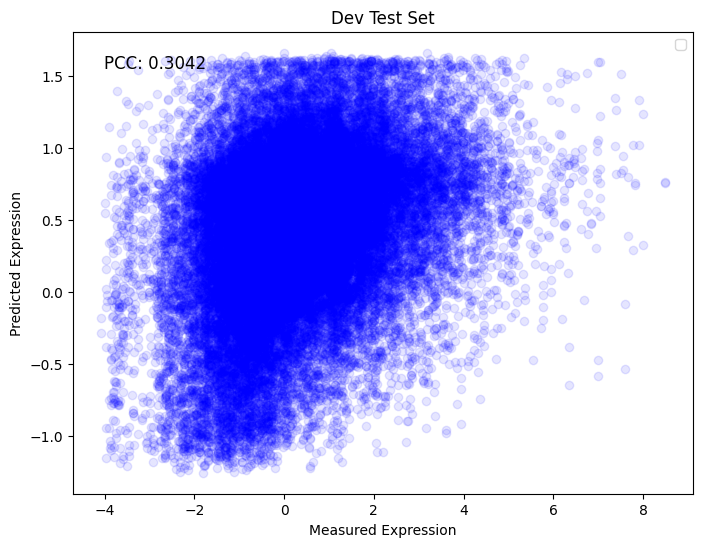

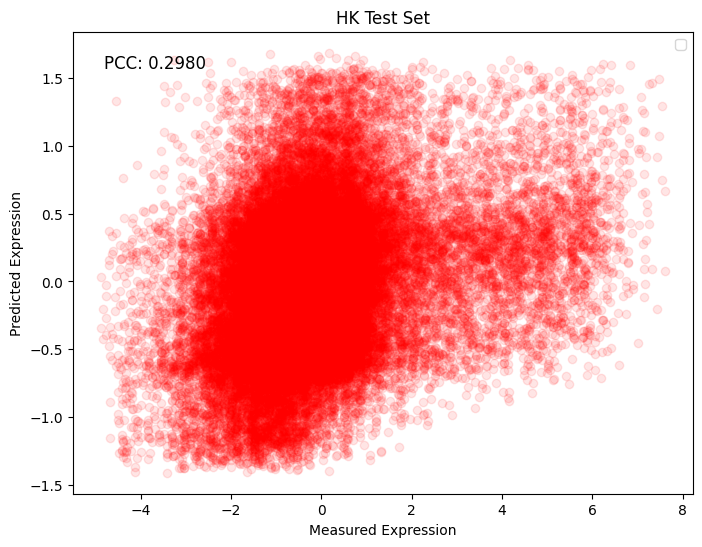

In [ ]:
import matplotlib.pyplot as plt

# Plot for predictions1
plt.figure(figsize=(8, 6))
plt.scatter(all_targets1.cpu().numpy(), all_predictions1.cpu().numpy(), color='blue', alpha = 0.1)
plt.xlabel('Measured Expression')
plt.ylabel('Predicted Expression')
plt.title('Dev Test Set')
plt.legend()

# Add Pearson correlation coefficient to the plot
plt.text(0.05, 0.95, f'PCC: {pcc1:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

# Show plot
plt.show()

# Plot for predictions2
plt.figure(figsize=(8, 6))
plt.scatter(all_targets2.cpu().numpy(), all_predictions2.cpu().numpy(), color='red', alpha = 0.1)
plt.plot(pcc1)
plt.xlabel('Measured Expression')
plt.ylabel('Predicted Expression')
plt.title('HK Test Set')
plt.legend()

# Add Pearson correlation coefficient to the plot
plt.text(0.05, 0.95, f'PCC: {pcc2:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

# Show plot
plt.show()